In [1]:
from __future__ import annotations

import time
import sys
from pathlib import Path
from typing import Any, Dict, Iterable, Optional, Tuple, Union

import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go

from sklearn.base import clone
from sklearn.utils import resample

In [2]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != "Thesis code" and PROJECT_ROOT != PROJECT_ROOT.parent:
    PROJECT_ROOT = PROJECT_ROOT.parent

sys.path.insert(0, str(PROJECT_ROOT))

from Functions.data_utils import (
    plot_incremental_response_rate,
    uplift_by_decile_bin,
    coerce_metrics_to_numeric,
    add_uplifts,
    uplift_mmoa
)



C:\Users\tsterk\AppData\Local\anaconda3\envs\causalml_py312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to import duecredit due to No module named 'duecredit'


In [3]:
file_path_2 = r"Data/df_preds.csv"
df_preds = pd.read_csv(file_path_2)

In [4]:
df_preds.head()

,p_cameback_0,p_cameback_1,p_cameback_2,p_cameback_3,p_cameback_4,p_cameback_5,p_cameback_6,p_cameback_8,p_cameback_9,p_no_cameback_0,...,p_no_cameback_5,p_no_cameback_6,p_no_cameback_8,p_no_cameback_9,y_true,y_pred,confidence,model,fold,correct
0,0.01,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.34,...,0.03,0.04,0.20,0.05,no_cameback_0,no_cameback_0,0.34,rf_uncal,1,True
1,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.51,...,0.12,0.05,0.05,0.02,no_cameback_8,no_cameback_0,0.51,rf_uncal,2,False
2,0.04,0.00,0.0,0.0,0.01,0.02,0.0,0.0,0.0,0.34,...,0.03,0.08,0.04,0.07,cameback_9,no_cameback_0,0.34,rf_uncal,2,False
3,0.05,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.42,...,0.01,0.03,0.06,0.05,no_cameback_0,no_cameback_0,0.42,rf_uncal,4,True
4,0.00,0.01,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.57,...,0.01,0.09,0.00,0.03,no_cameback_0,no_cameback_0,0.57,rf_uncal,1,True


In [5]:
################################################################################################
# Function to return the prior probabilities of treatments per treatment group, i.e. 0 = control
# Used for counteracting the imbalance of treatment groups
################################################################################################

def get_treatment_probs_from_y_true(
    df: pd.DataFrame,
    *,
    y_true_col: str = "y_true",
) -> Dict[int, float]:
    """
    Compute P(T=t) using only the last digit of y_true (e.g., 'cameback_3' -> 3).
    Returns a dict like {0: 0.52, 1: 0.11, ...}.
    """
    probs = (
        df[y_true_col]
        .astype(str)
        .str[-1]
        .astype(int)
        .value_counts(normalize=True)
        .sort_index()
        .to_dict()
    )

    return probs

treatment_probs = get_treatment_probs_from_y_true(df_preds, y_true_col='y_true')
treatment_probs


{0: 0.5024696939253901,
 1: 0.06182188065099457,
 2: 0.06404879110575314,
 3: 0.061876297635791305,
 4: 0.0626632509543902,
 5: 0.06435017748308887,
 6: 0.06265906503248275,
 8: 0.06122329381823053,
 9: 0.05888754939387851}

In [6]:
k_values = [1, 2, 3, 4,5,6,8,9]

df_preds_uplift = add_uplifts(
    df_preds,
    k_values=k_values,
    resp_prefix="cameback",
    nonresp_prefix="no_cameback",
    treatment_probs = treatment_probs
)

In [7]:
df_preds_uplift.head()

,p_cameback_0,p_cameback_1,p_cameback_2,p_cameback_3,p_cameback_4,p_cameback_5,p_cameback_6,p_cameback_8,p_cameback_9,p_no_cameback_0,...,fold,correct,uplift_1,uplift_2,uplift_3,uplift_4,uplift_5,uplift_6,uplift_8,uplift_9
0,0.01,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.34,...,1,True,0.009736,-0.904554,-0.797759,-0.939076,0.190557,0.018381,-2.609974,-0.192320
1,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.51,...,2,False,-0.117299,0.546594,0.206923,-0.580845,-0.849810,0.217017,0.198304,0.675356
2,0.04,0.00,0.0,0.0,0.01,0.02,0.0,0.0,0.0,0.34,...,2,False,-0.211724,-2.057176,-0.695851,-0.360448,0.441651,-0.679700,-0.056295,-0.591655
3,0.05,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.42,...,4,True,-1.366453,-1.293340,-0.233314,-0.221136,0.580963,0.257581,-0.243656,-0.112713
4,0.00,0.01,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.57,...,1,True,0.649132,-1.832092,0.649558,0.655647,0.978997,-0.301948,1.134397,0.624951


In [8]:
####################################################################################
# Test if uplift calculations are correct for first 10 rows
####################################################################################
df_cat = df_preds_uplift[df_preds_uplift["model"] == "catboost_uncal"]

# Treatment probabilities (same as uplift code)
pt = get_treatment_probs_from_y_true(df_cat)
pt0, pt1, pt2, pt3, pt4 = pt[0], pt[1], pt[2], pt[3], pt[4]

def manual_uplift(row, k, pt0, ptk):
    return (
        row[f"p_cameback_{k}"] / ptk
        + row["p_no_cameback_0"] / pt0
        - row[f"p_no_cameback_{k}"] / ptk
        - row["p_cameback_0"] / pt0
    )

rows = df_cat.head(10)

for idx, row in rows.iterrows():
    for k, ptk in zip([1, 2, 3, 4,5,6,7], [pt1, pt2, pt3, pt4]):
        manual = manual_uplift(row, k, pt0, ptk)
        stored = row[f"uplift_{k}"]

        # Exact comparison (default numpy tolerance)
        np.testing.assert_allclose(manual, stored)



print("\n✅ All 10 rows match for treatments 1–4")


✅ All 10 rows match for treatments 1–4


In [9]:
df_preds_uplift.head()

,p_cameback_0,p_cameback_1,p_cameback_2,p_cameback_3,p_cameback_4,p_cameback_5,p_cameback_6,p_cameback_8,p_cameback_9,p_no_cameback_0,...,fold,correct,uplift_1,uplift_2,uplift_3,uplift_4,uplift_5,uplift_6,uplift_8,uplift_9
0,0.01,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.34,...,1,True,0.009736,-0.904554,-0.797759,-0.939076,0.190557,0.018381,-2.609974,-0.192320
1,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.51,...,2,False,-0.117299,0.546594,0.206923,-0.580845,-0.849810,0.217017,0.198304,0.675356
2,0.04,0.00,0.0,0.0,0.01,0.02,0.0,0.0,0.0,0.34,...,2,False,-0.211724,-2.057176,-0.695851,-0.360448,0.441651,-0.679700,-0.056295,-0.591655
3,0.05,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.42,...,4,True,-1.366453,-1.293340,-0.233314,-0.221136,0.580963,0.257581,-0.243656,-0.112713
4,0.00,0.01,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.57,...,1,True,0.649132,-1.832092,0.649558,0.655647,0.978997,-0.301948,1.134397,0.624951


In [10]:
####################################################################################
# Transformations for easy processing
####################################################################################
# 1 if cameback, 0 if no_cameback
df_preds_uplift["y_true_label"] = (
    ~df_preds_uplift["y_true"].str.contains("no_cameback")
).astype(int)

# last digit from y_true is treatment assingment (0,1,2 ... 9)
df_preds_uplift["treatmentgroup"] = (
    df_preds_uplift["y_true"]
    .str.extract(r'_(\d+)$')[0]
    .astype(int))

In [11]:
df_preds_uplift.head()

,p_cameback_0,p_cameback_1,p_cameback_2,p_cameback_3,p_cameback_4,p_cameback_5,p_cameback_6,p_cameback_8,p_cameback_9,p_no_cameback_0,...,uplift_1,uplift_2,uplift_3,uplift_4,uplift_5,uplift_6,uplift_8,uplift_9,y_true_label,treatmentgroup
0,0.01,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.34,...,0.009736,-0.904554,-0.797759,-0.939076,0.190557,0.018381,-2.609974,-0.192320,0,0
1,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.51,...,-0.117299,0.546594,0.206923,-0.580845,-0.849810,0.217017,0.198304,0.675356,0,8
2,0.04,0.00,0.0,0.0,0.01,0.02,0.0,0.0,0.0,0.34,...,-0.211724,-2.057176,-0.695851,-0.360448,0.441651,-0.679700,-0.056295,-0.591655,1,9
3,0.05,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.42,...,-1.366453,-1.293340,-0.233314,-0.221136,0.580963,0.257581,-0.243656,-0.112713,0,0
4,0.00,0.01,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.57,...,0.649132,-1.832092,0.649558,0.655647,0.978997,-0.301948,1.134397,0.624951,0,0


In [12]:
#####################################################################################################
# Getting the maximum uplift i.e. best treatment per customer.
# Filter dataset when given treatment is equal to recommended treatment or treatment is control group
#####################################################################################################

uplift_cols = ["uplift_1",'uplift_2','uplift_3','uplift_4','uplift_5','uplift_6','uplift_8', 'uplift_9'] #,'uplift_7','uplift_9'

# Add optimal lift to the dataframe
df_preds_uplift["optimal_lift"] = df_preds_uplift[uplift_cols].max(axis=1)

# Find the the treatment with highest uplift 
best_treatment = (
    df_preds_uplift[uplift_cols]
    .idxmax(axis=1) # return column name where column is max value of uplift
    .str.split("_")
    .str[1]
    .astype(int)
)

# Keep rows where the treatment is either control, or given treatment is equal to the treatment with highest uplift
df_preds_uplift = df_preds_uplift[
    (df_preds_uplift["treatmentgroup"] == 0)
    | (df_preds_uplift["treatmentgroup"] == best_treatment)
]


In [13]:
df_preds.shape[0] / 4

238896.0

In [14]:
df_preds_uplift.shape[0] / 4

134868.0

In [15]:
# per model sort customers by uplift
df_preds_uplift = df_preds_uplift.sort_values(["model", "optimal_lift"], ascending=False)


In [16]:
df_preds_uplift.head()

,p_cameback_0,p_cameback_1,p_cameback_2,p_cameback_3,p_cameback_4,p_cameback_5,p_cameback_6,p_cameback_8,p_cameback_9,p_no_cameback_0,...,uplift_2,uplift_3,uplift_4,uplift_5,uplift_6,uplift_8,uplift_9,y_true_label,treatmentgroup,optimal_lift
198078,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.73,0.139397,...,0.277423,-1.833295,0.277423,0.277423,0.277423,0.277423,12.673931,0,0,12.673931
174958,0.0,0.648591,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.262736,...,-0.570028,0.522889,0.522889,0.522889,0.384477,0.522889,0.522889,0,0,10.852424
190094,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.61,0.00,0.281316,...,0.559867,0.559867,0.400284,0.559867,-0.238102,10.523395,0.390052,0,0,10.523395
205462,0.0,0.000000,0.0,0.0,0.64,0.0,0.0,0.00,0.00,0.110000,...,0.218919,0.218919,10.432241,0.218919,0.218919,0.218919,-4.026461,0,0,10.432241
127484,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.00,0.60,0.118769,...,-0.075891,0.236371,-3.772852,0.236371,0.236371,0.073034,10.425282,0,0,10.425282


In [21]:
df_preds_uplift[
    (df_preds_uplift["model"] == "catboost_calibrated_dirichlet") &
    (df_preds_uplift["y_true_label"] == 1)
]["treatmentgroup"].value_counts()

treatmentgroup
0    1443
4      51
1      29
5      28
6      25
9      23
2      22
8      20
3      15
Name: count, dtype: int64

In [18]:
qini_bins_by_model = (
    df_preds_uplift
    .groupby("model")
    .apply(lambda g: uplift_by_decile_bin(
        g,
        treatment_col="treatmentgroup",
        outcome_col="y_true_label",
        size=10,
       binary_uplift = False 
    ))
    .reset_index(level=0)
)



In [19]:
qini_bins_by_model

,model,bin,bin_start_idx,bin_end_idx,bin_n,treated_n,control_n,treated_converted_n,control_converted_n,treated_rate,control_rate,uplift,cum_treated_n,cum_control_n,cum_treated_converted_n,cum_control_converted_n,cum_treated_rate,cum_control_rate,cum_population_frac,inc_gains
0,catboost_calibrated_dirichlet,1,0,13488,13488,1510,11978,43,249,0.028477,0.020788,0.007689,1510,11978,43,249,0.028477,0.020788,0.100000,0.000769
1,catboost_calibrated_dirichlet,2,13488,26976,13488,1551,11937,33,206,0.021277,0.017257,0.004019,3061,23915,76,455,0.024828,0.019026,0.200000,0.001161
2,catboost_calibrated_dirichlet,3,26976,40464,13488,1485,12003,28,230,0.018855,0.019162,-0.000307,4546,35918,104,685,0.022877,0.019071,0.300000,0.001142
3,catboost_calibrated_dirichlet,4,40464,53952,13488,1532,11956,27,167,0.017624,0.013968,0.003656,6078,47874,131,852,0.021553,0.017797,0.400000,0.001503
4,catboost_calibrated_dirichlet,5,53952,67440,13488,1438,12050,21,139,0.014604,0.011535,0.003068,7516,59924,152,991,0.020224,0.016538,0.500000,0.001843
5,catboost_calibrated_dirichlet,6,67440,80928,13488,1452,12036,10,134,0.006887,0.011133,-0.004246,8968,71960,162,1125,0.018064,0.015634,0.600000,0.001458
6,catboost_calibrated_dirichlet,7,80928,94416,13488,1455,12033,15,112,0.010309,0.009308,0.001002,10423,83993,177,1237,0.016982,0.014727,0.700000,0.001578
7,catboost_calibrated_dirichlet,8,94416,107904,13488,1466,12022,16,88,0.010914,0.007320,0.003594,11889,96015,193,1325,0.016233,0.013800,0.800000,0.001947
8,catboost_calibrated_dirichlet,9,107904,121392,13488,1486,12002,8,72,0.005384,0.005999,-0.000615,13375,108017,201,1397,0.015028,0.012933,0.900000,0.001885
9,catboost_calibrated_dirichlet,10,121392,134880,13488,1467,12021,12,46,0.008180,0.003827,0.004353,14842,120038,213,1443,0.014351,0.012021,1.000000,0.002330


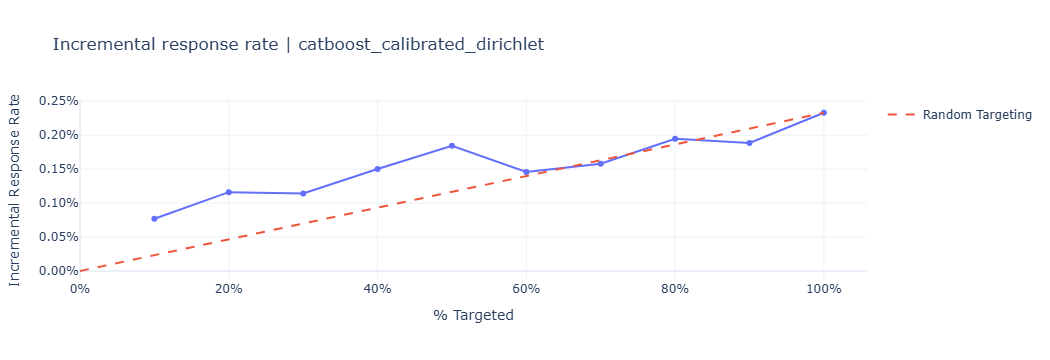

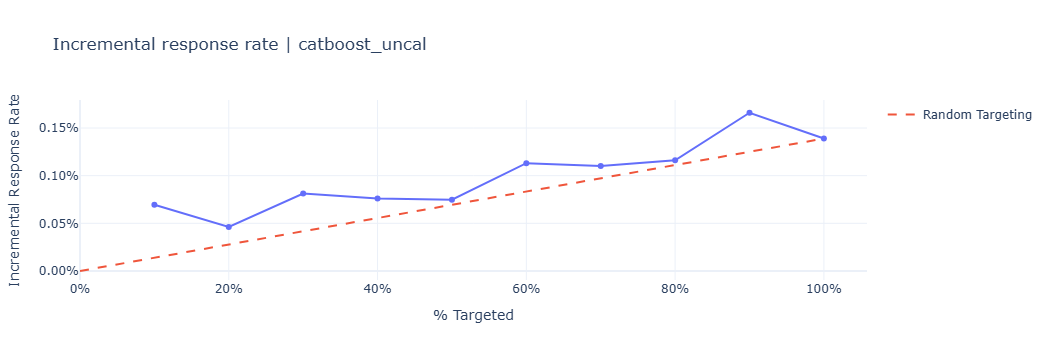

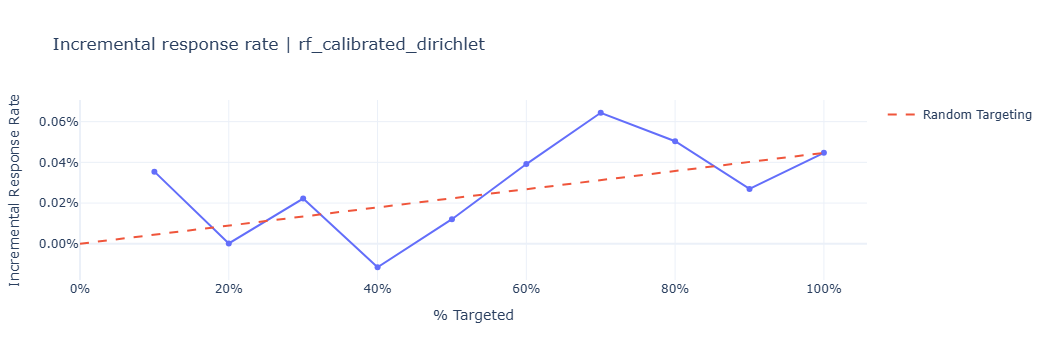

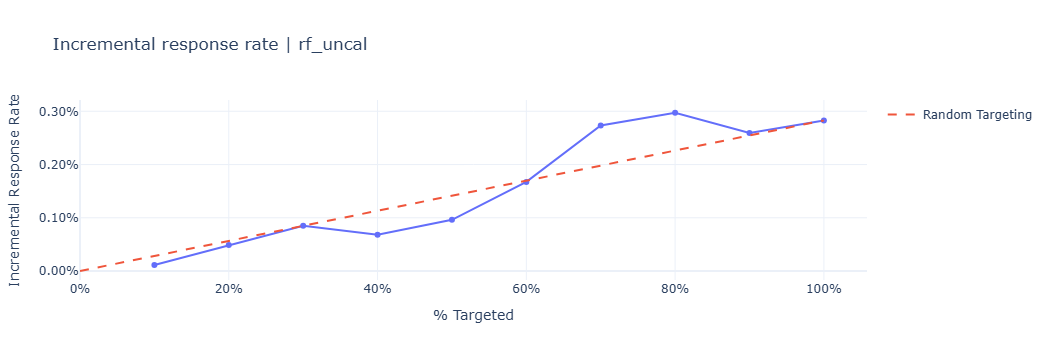

In [20]:
for model, g in qini_bins_by_model.groupby("model"):
    fig = plot_incremental_response_rate(g)
    fig.update_layout(title=f"Incremental response rate | {model}")
    fig.show()
